# Esercitazione di Laboratorio n.3

#### Autore: Davide Cernuzio

Questa esercitazione è incentrata sull'applicazione dell'algoritmo di Metropolis ad un caso unidimensionale.

- *Parte I: Algoritmo di Metropolis*

Una particella è confinata in un potenziale dato dalla funzione:

$\large V(x) = -0.1 \; (x^2 + 0.3) \; e^{-(x - 0.1)^2}$

La particella è anche a contatto con una sorgente di calore a temperatura $T \equiv k\ t$, ove $T$ è espressa in $MeV$. La probabilità di trovare la particella in una posizione $x$ è data dalla distribuzione di Boltzmann:

$\displaystyle \large p(x) = \frac{e^{-\frac{V(x)}{T}}}{Z}$

Il programma dovrebbe eseguire i seguenti passi dopo aver implementato una funzione che calcola l'energia potenziale per ogni posizione data nell'intervallo $[-3,3]$:

1. Inizializzare la posizione iniziale della particella, ad esempio $x_{cur}=x_0$ dove $x_0$ è scelta dall'utente;
2. Calcolare la sua energia $E_{cur} = V(x_{cur})$;
3. Proporre una nuova posizione $x_{new} = x_{cur} + (2\xi - 1) \; \delta$, ove $\xi$ è generata uniformemente in $[0,1]$;
4. Calcolare l'energia della posizione proposta $E_{new}=V(x_{new})$;
5. Accettare la nuova posizione secondo la probabilità;
6. Memorizzare alcune quantità quali posizione e energia;
7. Ritornare al punto 3.

Dopo un numero prefissato di passi, calcolare i valori medi della posizione e della energia.
Utilizzare $T=0.05\ MeV$ e verificare se le medie sono le stesse al variare della posizione iniziale.

Ripetere il calcolo per valori crescenti di $T$ e tracciare una curva della energia media, posizione media e calore specifico al variare di $T$. I risultati ottenuti sono quelli aspettati?

Infine, aggiungere una seconda particella, e considerare il seguente potenziale di interazione fra le due particelle

$\displaystyle \large V(x_1,x_2)=-\frac{1}{10} \; (x_1 - x_2)^2$

Qual è la minima distanza tra le particelle a $T=0.1\ MeV$?

In [92]:
#Inizializzazione dei parametri principali, definizione di V(x), p(x; T), definizione delle funzioni per gli integrali
#numerici e per l'algoritmo di Metropolis. Calcolo della normalizzazione e dei momenti di x e V(x).

import numpy as np
import matplotlib.pyplot as plt
from random import random, uniform
from time import time
t0=time()

N = 1*10**6
first = 180

T0 = 0.05
Ti, Tf = T0, 40*T0

x_start, x_stop = -3., 3.
x0, δ = 0.908, (x_stop - x_start)/4


t_list  = np.linspace(Ti, Tf, 10)
x0_list = np.linspace(x_start, x_stop, 10)


V = lambda x: -.1 * (x**2 + .3) * np.exp(-(x - .1)**2)

def p(x, T=T0):
    if x_start <= x <= x_stop:
        return np.exp(-V(x)/T)
    else: return -np.inf

V_vec, p_vec = np.vectorize(V), np.vectorize(p)


def integrate(f, a=x_start, b=x_stop, n=6000):
    n = 2 * int(n/2)
    h = (b-a)/n
    s0 = f(a) + f(b)
    s2,s4 = 0,0
    
    for k in range(1, n, 2):
        s4 += f(a + k*h)
        s2 += f(a + (k+1)*h)
    s2 -= f(b)
    
    return h/3 * (s0 + 2*s2 + 4*s4)


z    = round(integrate(p), 8)
μ_x  = round(integrate(lambda x: x*p(x))/z, 10)
σ2_x = round(integrate(lambda x: (x - μ_x)**2*p(x))/z, 8)
μ_v  = round(integrate(lambda x: V(x)*p(x))/z, 10)
σ2_v = round(integrate(lambda x: (V(x) - μ_v)**2*p(x))/z, 11)


def Metropolis(x_in=x0, T=T0, n=N):

    global Sample_x, Sample_v
    global av_x, var_x, av_v, var_v
    global rej
    
    Sample_x, Sample_v = [x_in], [V(x_in)]
    xi = x_in
    rej = 0
    for i in range(n-1):
        x = uniform(xi-δ, xi+δ)
        if p(x,T) >= p(xi,T):
            Sample_x.append(x)
            Sample_v.append(V(x))
            xi = x
        else:
            ξ = random()
            if p(xi,T)*ξ <= p(x,T):
                Sample_x.append(x)
                Sample_v.append(V(x))
                xi = x
            else:
                Sample_x.append(xi)
                Sample_v.append(V(xi))
                rej += 1

    Sum_x, Sum_v, Sum2_x, Sum2_v = 0,0,0,0
    for x,v in zip(Sample_x, Sample_v):
        Sum_x  += x
        Sum2_x += x**2
        Sum_v  += v
        Sum2_v += v**2

    av_x, var_x = Sum_x/n, (Sum2_x - Sum_x**2/n)/(n-1)
    av_v, var_v = Sum_v/n, (Sum2_v - Sum_v**2/n)/(n-1)

t=time()-t0
print('Tempo di esecuzione:',round(t,3),'s')

Tempo di esecuzione: 0.212 s


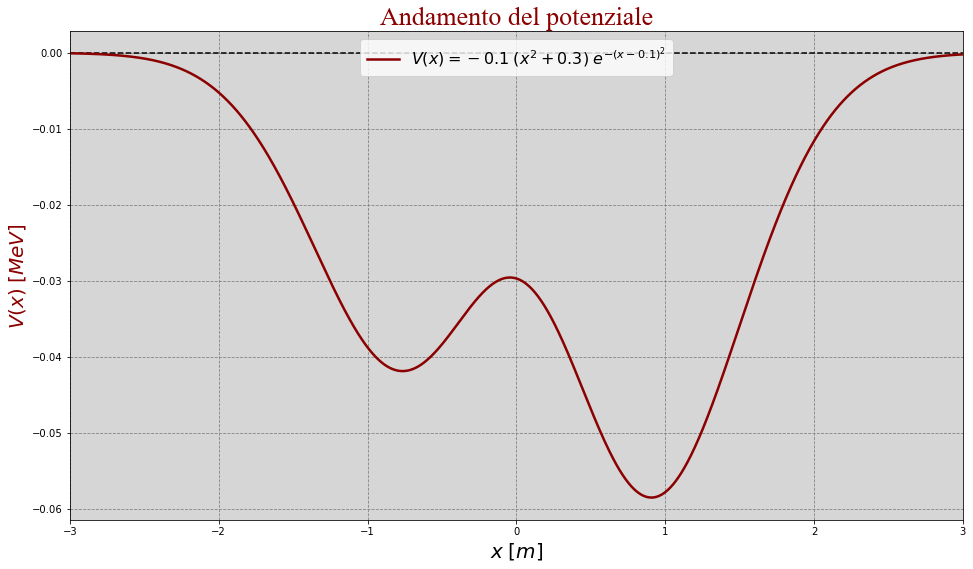

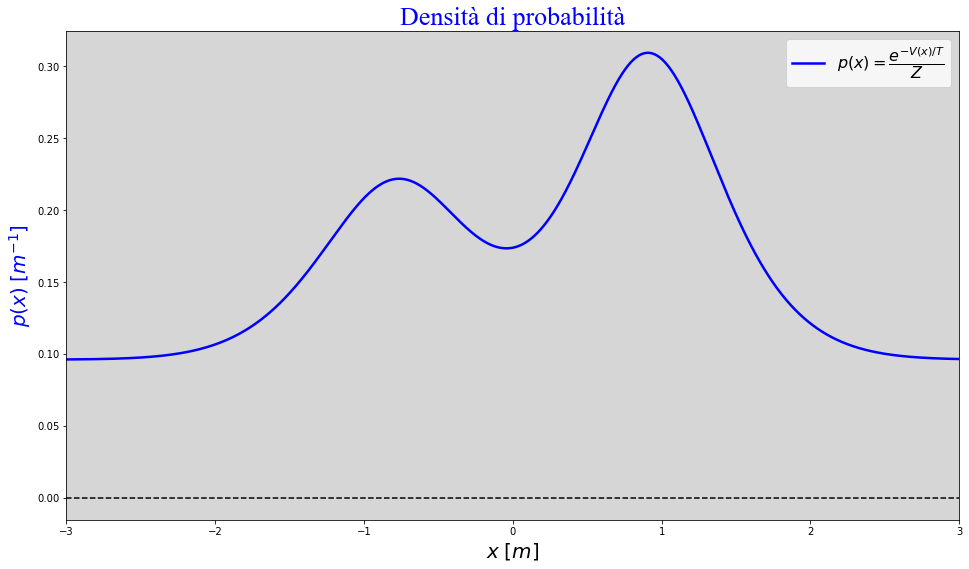

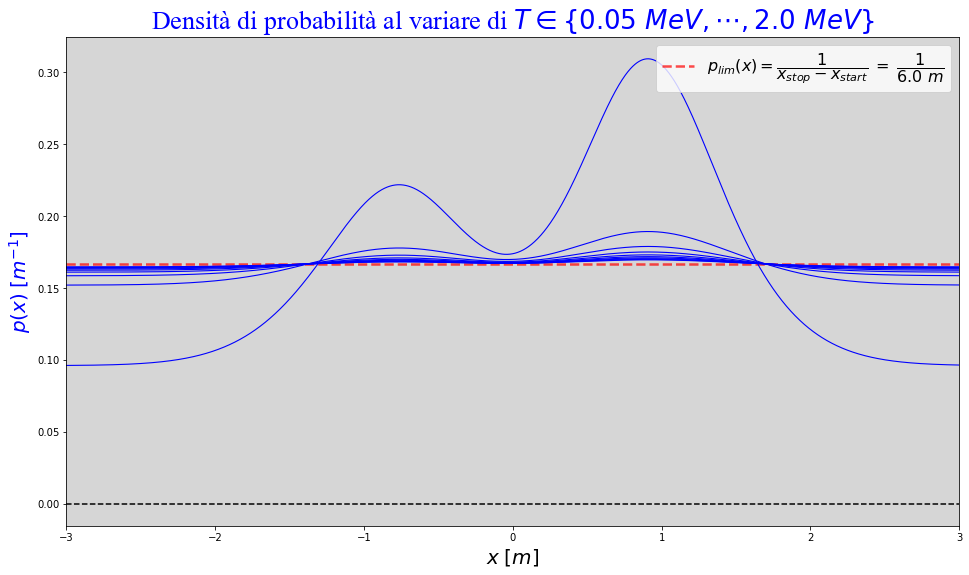

In [93]:
#Andamento di V(x)

font1={'family':'times new roman','color':'darkblue','size':26}
X = np.linspace(x_start, x_stop, 2000)

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Andamento del potenziale', fontdict = font1, c='darkred')

plt.plot([x_start,x_stop],[0,0],'--k')
plt.plot(X, V_vec(X), c='darkred', lw=2.5, label = '$V(x)= -0.1\;(x^2+0.3)\; e^{-(x -0.1)^2}$')

plt.xlabel('$x \; [m]$', size=20)
plt.ylabel('$V(x) \; [MeV]$', c='darkred', size=20)
plt.legend(fontsize=16, loc='upper center')
plt.xlim(x_start, x_stop)
plt.grid(c='grey',ls='--')
plt.show()


#Andamento di p(x; T = 0.05 MeV)

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Densità di probabilità', fontdict = font1, c='blue')

plt.plot([x_start,x_stop],[0,0],'--k')
plt.plot(X, p_vec(X)/z, c='blue', lw=2.5, label = r'$p(x) = \dfrac{e^{-V(x)/T}}{Z}$')

plt.xlabel('$x \; [m]$', size=20)
plt.ylabel('$p(x) \; [m^{-1}]$', c='blue', size=20)
plt.legend(fontsize=16)
plt.xlim(x_start, x_stop)
plt.show()


#Grafico di p(x) al crescere di T

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Densità di probabilità al variare di $T \in \{'+str(Ti)+'\ MeV,\cdots,'+str(Tf)+'\ MeV\}$',
          fontdict = font1, c='blue')

plt.plot([x_start,x_stop],[0,0],'--k')
plt.plot([x_start,x_stop],[1/(x_stop-x_start), 1/(x_stop-x_start)],'--r',lw=2.5,alpha=.7,
        label = r'$p_{lim}(x)=\dfrac{1}{x_{stop}-x_{start}} \; = \; \dfrac{1}{'+str(round(x_stop-x_start,2))+'\ m}$')

for t in t_list:
    z_t = round(integrate(lambda x: p(x,t), n=10**5), 11)
    plt.plot(X, p_vec(X,t)/z_t, c='blue', lw=1.1)

plt.xlabel('$x \; [m]$', size=20)
plt.ylabel('$p(x) \; [m^{-1}]$', c='blue', size=20)
plt.xlim(x_start, x_stop)
plt.legend(fontsize=16, loc='upper right')
plt.show()

In [94]:
#Esecuzione dell'algoritmo di Metropolis. Output dei risultati ottenuti.

t=time()
Metropolis()
t=time()-t

print('Tempo di esecuzione:',round(t,3),'s')
print('N                  :',N)
print('Accettati          :', round( 100*(1 - rej/(N-1)), 3) ,'%\n')

print('μ_x (stimata) :', round(av_x, 6),'m')
print('μ_x (attesa)  :', round(μ_x,  6),'m')
print('σ2_x (stimata):', round(var_x,6),'m²')
print('σ2_x (attesa) :', round(σ2_x, 6),'m²\n')

print('μ_v (stimata) :', round(av_v, 6),'MeV')
print('μ_v (attesa)  :', round(μ_v,  6),'MeV')
print('σ2_v (stimata):', round(var_v,6),'MeV²')
print('σ2_v (attesa) :', round(σ2_v, 6),'MeV²\n')

print('Errore μ_x    :', round(100*(av_x  - μ_x) / μ_x, 4),'%')
print('Errore σ2_x   :', round(100*(var_x - σ2_x)/ σ2_x,4),'%')
print('Errore μ_v    :', round(100*(av_v  - μ_v) / μ_v, 4),'%')
print('Errore σ2_v   :', round(100*(var_v - σ2_v)/ σ2_v,4),'%')

Tempo di esecuzione: 13.478 s
N                  : 1000000
Accettati          : 78.247 %

μ_x (stimata) : 0.109641 m
μ_x (attesa)  : 0.116838 m
σ2_x (stimata): 2.169878 m²
σ2_x (attesa) : 2.16317 m²

μ_v (stimata) : -0.031177 MeV
μ_v (attesa)  : -0.031227 MeV
σ2_v (stimata): 0.000355 MeV²
σ2_v (attesa) : 0.000354 MeV²

Errore μ_x    : -6.1599 %
Errore σ2_x   : 0.3101 %
Errore μ_v    : -0.1603 %
Errore σ2_v   : 0.2327 %


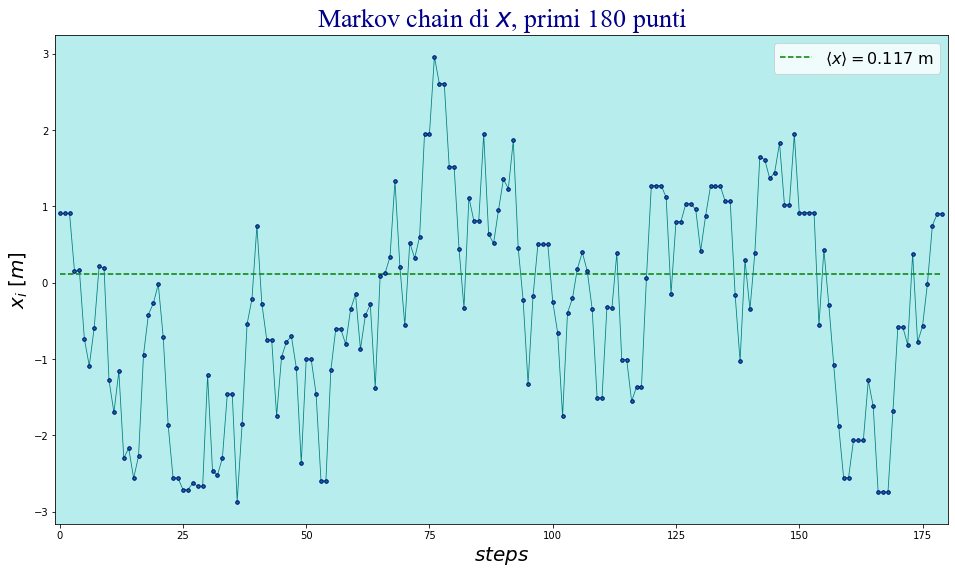

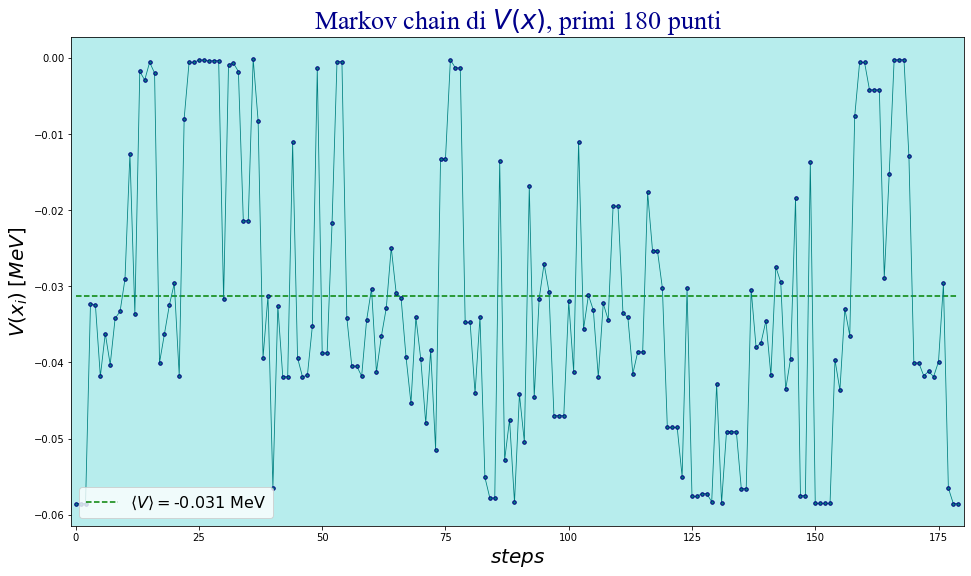

In [95]:
#Primi punti della Markov chain di x e V(x)

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#b7eded')
plt.title('Markov chain di $x$, primi '+str(first)+' punti', fontdict=font1)

plt.plot([0,first-1], [μ_x,μ_x], '--', c='green', label=r'$\langle x \rangle =$'+str(round(μ_x,3))+' m')
plt.plot(Sample_x[:first], 'o-', c='teal', mec='navy', ms=3.5, lw=0.8)

plt.xlabel('$steps$', size=20)
plt.ylabel('$x_i\; [m]$', size=20)
plt.legend(fontsize=16)
plt.xlim(-0.005*first,1.001*first)
plt.show()


plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#b7eded')
plt.title('Markov chain di $V(x)$, primi '+str(first)+' punti', fontdict=font1)

plt.plot([0,first-1], [μ_v,μ_v], '--', c='green', label=r'$\langle V \rangle =$'+str(round(μ_v,3))+' MeV')
plt.plot(Sample_v[:first], 'o-', c='teal', mec='navy', ms=3.5, lw=0.8)

plt.xlabel('$steps$', size=20)
plt.ylabel('$V(x_i)\; [MeV]$', size=20)
plt.legend(fontsize=16)
plt.xlim(-0.005*first,1.001*first)
plt.show()

In [80]:
#Ricerca dei punti stazionari di V(x) e inversione numerica

t=time()

ε1 = 10**(-15)     #per la tolleranza sui punti stazionari
ε2 = 10**(-12)     #per la tolleranza sull'inversione
ε3 = 10**(-6)      #per il calcolo della derivata


pol = lambda x: x**3 - .1*x**2 - .7*x - .03

def zero(a, b):
    c = (a+b)/2
    
    while abs(b-a) >= ε1:
        c = (a+b)/2
        
        if pol(c) == 0:
            break
            
        elif pol(a)*pol(c) > 0:
            a = c
        else:
            b = c
    
    return c

x1 = x_start
x2 = round(zero(-1.,-.5), 15)
x3 = round(zero(-.5, .5), 15)
x4 = round(zero(.5 , 1.), 15)
x5 = x_stop


def inv(y, xi, xf):
    a,b = xi,xf
    x = (a+b)/2
    
    if V(xf)>V(xi):
        while abs(V(x)/y - 1) > ε2:
            if V(x)<y:
                a = x
                x = (a+b)/2
            else:
                b = x
                x = (a+b)/2
        return x
    
    else:
        while abs(V(x)/y - 1) > ε2:
            if V(x)>y:
                a = x
                x = (a+b)/2
            else:
                b = x
                x = (a+b)/2
        return x


def der(y, xi, xf):

    if (xi,xf) == (x1,x2):
        
        if abs(y - V(x1)) < ε3:
            return (inv(y - ε3, x1, x2) - inv(y, x1, x2)) / (-ε3)
        elif abs(y - V(x2)) < ε3:
            return (inv(y + ε3, x1, x2) - inv(y, x1, x2)) / ε3
        else: return (inv(y + ε3, x1, x2) - inv(y - ε3, x1, x2)) / (2*ε3)

    elif (xi,xf) == (x2,x3):
        
        if abs(y - V(x2)) < ε3:
            return (inv(y + ε3, x2, x3) - inv(y, x2, x3)) / ε3
        elif abs(y - V(x3)) < ε3:
            return (inv(y - ε3, x2, x3) - inv(y, x2, x3)) / (-ε3)
        else: return (inv(y + ε3, x2, x3) - inv(y - ε3, x2, x3)) / (2*ε3)

    elif (xi,xf) == (x3,x4):
        
        if abs(y - V(x4)) < ε3:
            return (inv(y - ε3, x3, x4) - inv(y, x3, x4)) / (-ε3)
        elif abs(y - V(x4)) < ε3:
            return (inv(y + ε3, x3, x4) - inv(y, x3, x4)) / ε3
        else: return (inv(y + ε3, x3, x4) - inv(y - ε3, x3, x4)) / (2*ε3)

    elif (xi,xf) == (x4,x5):
        
        if abs(y - V(x4)) < ε3:
            return (inv(y + ε3, x4, x5) - inv(y, x4, x5)) / ε3
        elif abs(y - V(x5)) < ε3:
            return (inv(y - ε3, x4, x5) - inv(y, x4, x5)) / (-ε3)
        else: return (inv(y + ε3, x4, x5) - inv(y - ε3, x4, x5)) / (2*ε3)


v1, v2, v3, v4, v5 = V(x1), V(x2), V(x3), V(x4), V(x5)
v_m, v_M   = min(v1, v5), max(v1, v5)

def f(y):
    if y==v2 or y==v3 or y==v4:
        return np.nan
    elif v4 < y < v2:
        return -p(inv(y, x3, x4))*der(y, x3, x4) + p(inv(y, x4, x5))*der(y, x4, x5)
    elif v2 < y < v3:
        return -p(inv(y, x1, x2))*der(y, x1, x2) + p(inv(y, x2, x3))*der(y, x2, x3) - p(inv(y, x3, x4))*der(y, x3, x4) + p(inv(y, x4, x5))*der(y, x4, x5)
    elif v3 < y <= v_m:
        return -p(inv(y, x1, x2))*der(y, x1, x2) + p(inv(y, x4, x5))*der(y, x4, x5)
    elif v_m < y <= v_M:
        return -p(inv(y, x1, x2))*der(y, x1, x2)
    else: return 0.

f_vec = np.vectorize(f)

Y1,Y2,Y3 = np.linspace(v4, v2, 1000), np.linspace(v2, v3, 1000), np.linspace(v3, v_M, 1000)
F1, F2, F3 = f_vec(Y1), f_vec(Y2), f_vec(Y3)

t=time()-t
print('Tempo di esecuzione:',round(t,3),'s')

Tempo di esecuzione: 4.183 s


(x_1, v_1) = (-3.0 m, -6e-05 MeV)
(x_2, v_2) = (-0.7644 m, -0.04189 MeV)
(x_3, v_3) = (-0.04324 m, -0.02957 MeV)
(x_4, v_4) = (0.90764 m, -0.05853 MeV)
(x_5, v_5) = (3.0 m, -0.00021 MeV)


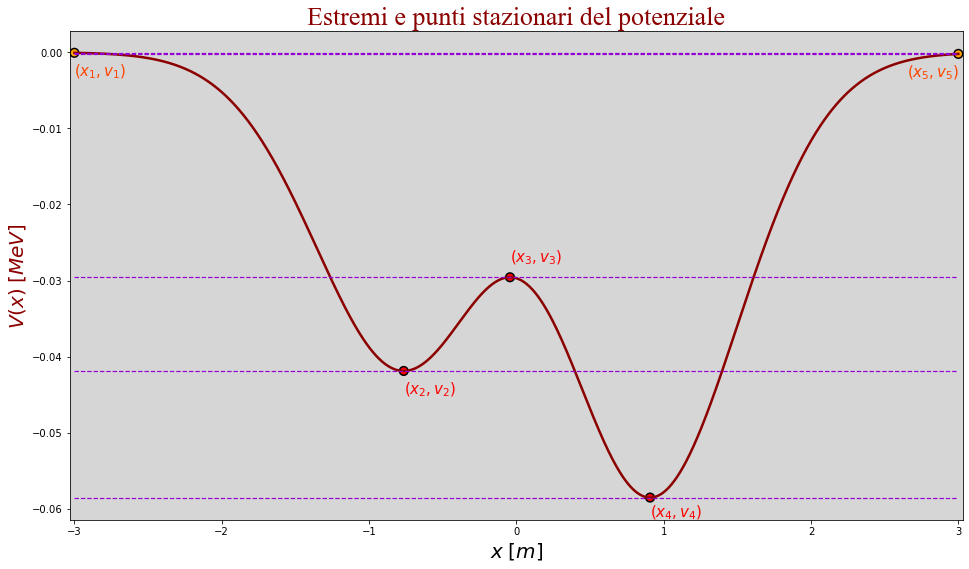

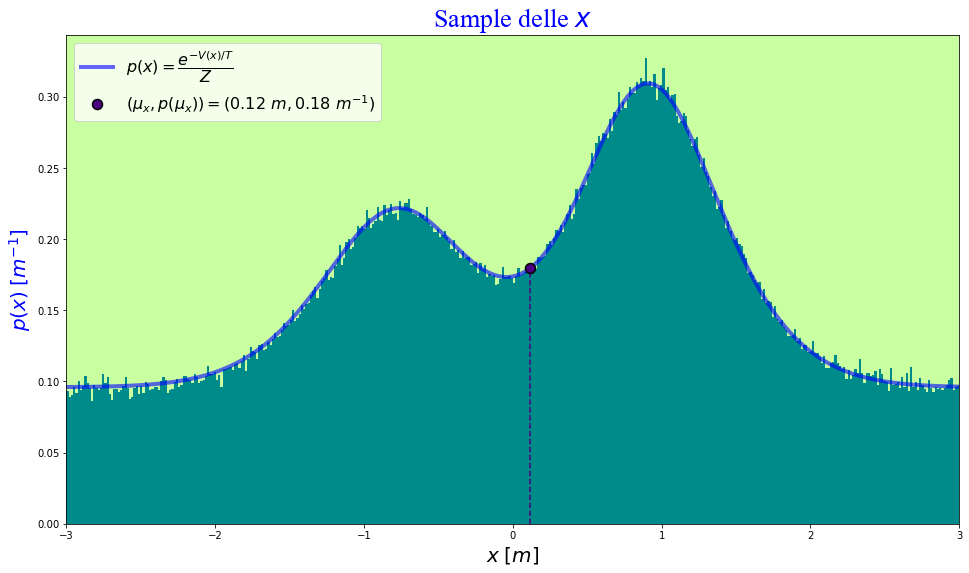

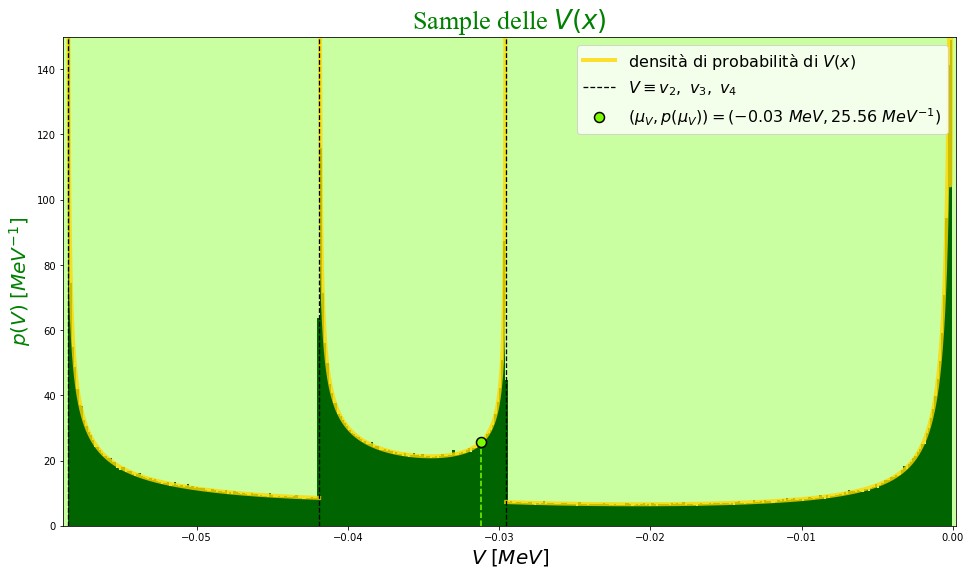

In [81]:
#Estremi e punti stazionari del potenziale

for i,x,v in zip(range(5), [x1,x2,x3,x4,x5], [v1,v2,v3,v4,v5]):
    print('(x_' +str(i+1)+ ', v_' +str(i+1)+ ') = (' +str(round(x,5))+ ' m, ' +str(round(v,5))+ ' MeV)')

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Estremi e punti stazionari del potenziale', fontdict = font1, c='darkred')

plt.plot(X, V_vec(X), c='darkred', lw=2.5)
plt.scatter([x1,x2,x3,x4,x5], [v1,v2,v3,v4,v5], s=75, lw=1.5, ec='k', c=['orange','r','r','r','orange'], alpha=1)
for v in [v1,v2,v3,v4,v5]:
    plt.plot([x1,x5], [v,v], '--', c='darkviolet', lw=1.2)

plt.text(s='$(x_1, v_1)$', x = x1, y = v1-.003, c='orangered', size=15)
plt.text(s='$(x_2, v_2)$', x = x2, y = v2-.003, c='r', size=15)
plt.text(s='$(x_3, v_3)$', x = x3, y = v3+.002, c='r', size=15)
plt.text(s='$(x_4, v_4)$', x = x4, y = v4-.0025, c='r', size=15)
plt.text(s='$(x_5, v_5)$', x = x5-.35, y = v5-.003, c='orangered', size=15)

plt.xlabel('$x \; [m]$', size=20)
plt.ylabel('$V(x) \; [MeV]$', c='darkred', size=20)
plt.xlim(x1*1.01, x5*1.01)
plt.show()


#Distribuzioni di x e di V(x)

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#c9ffa1')
plt.title('Sample delle $x$', fontdict = font1, c='blue')

plt.hist(Sample_x, bins=400, density=True, color='darkcyan')
plt.plot(X, p_vec(X)/z, c='blue', lw=4, alpha=.6, label = r'$p(x) = \dfrac{e^{-V(x)/T}}{Z}$')
plt.plot([μ_x,μ_x],[0,p(μ_x)/z],'--', c='indigo')
plt.plot([μ_x],[p(μ_x)/z],'o', c='indigo', ms=10, mec='k', mew=1.5,
         label='$(\mu_x, p(\mu_x)) = ('+str(round(μ_x, 2))+'\ m,'+str(round(p(μ_x)/z, 2))+'\ m^{-1})$')

plt.xlabel('$x \; [m]$', size=20)
plt.ylabel('$p(x) \; [m^{-1}]$', c='blue', size=20)
plt.legend(fontsize=16)
plt.xlim(x_start, x_stop)
plt.show()


plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#c9ffa1')
plt.title('Sample delle $V(x)$', fontdict = font1, c='green')

plt.hist(Sample_v, bins=400, density=True, color='darkgreen')
plt.plot(Y1, F1/z, c='gold', lw=4, alpha=.8, label='densità di probabilità di $V(x)$')
plt.plot(Y2, F2/z, c='gold', lw=4, alpha=.8)
plt.plot(Y3, F3/z, c='gold', lw=4, alpha=.8)
plt.plot([v2,v2],[0,150],'--k',lw=1.3)
plt.plot([v3,v3],[0,150],'--k',lw=1.3)
plt.plot([v4,v4],[0,150],'--k',lw=1.3,label='$V \equiv v_2,\ v_3,\ v_4$')
plt.plot([μ_v,μ_v],[0,f(μ_v)/z],'--', c='lawngreen')
plt.plot([μ_v],[f(μ_v)/z],'o', c='lawngreen', ms=10, mec='k', mew=1.5,
         label='$(\mu_V, p(\mu_V)) = ('+str(round(μ_v, 2))+'\ MeV,'+str(round(f(μ_v)/z, 2))+'\ MeV^{-1})$')

plt.xlabel('$V \; [MeV]$', size=20)
plt.ylabel('$p(V) \; [MeV^{-1}]$', c='green', size=20)
plt.xlim(1.005*v4, .0002)
plt.ylim(0,150)
plt.legend(fontsize=16)
plt.show()

In [89]:
#Andamento di medie e varianze al variare di x0:

t=time()
av_x_list, var_x_list = [], []
av_v_list, var_v_list = [], []

j=0
for x0 in x0_list:
    Metropolis(x0)
    av_x_list.append(av_x)
    av_v_list.append(av_v)
    var_x_list.append(var_x)
    var_v_list.append(var_v)
    j+=1
    print('Completamento operazione:',round(100*j/len(x0_list), 1),'%')

t=time()-t
print('Tempo di esecuzione:',int(t//60),'m',int(round(t%60,0)),'s')

Completamento operazione: 10.0 %
Completamento operazione: 20.0 %
Completamento operazione: 30.0 %
Completamento operazione: 40.0 %
Completamento operazione: 50.0 %
Completamento operazione: 60.0 %
Completamento operazione: 70.0 %
Completamento operazione: 80.0 %
Completamento operazione: 90.0 %
Completamento operazione: 100.0 %
Tempo di esecuzione: 3 m 8 s


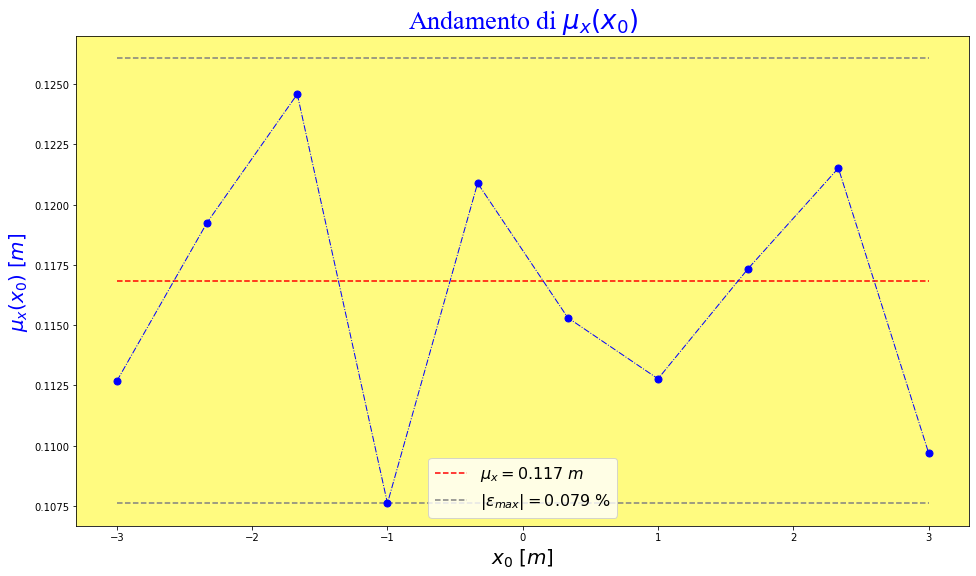

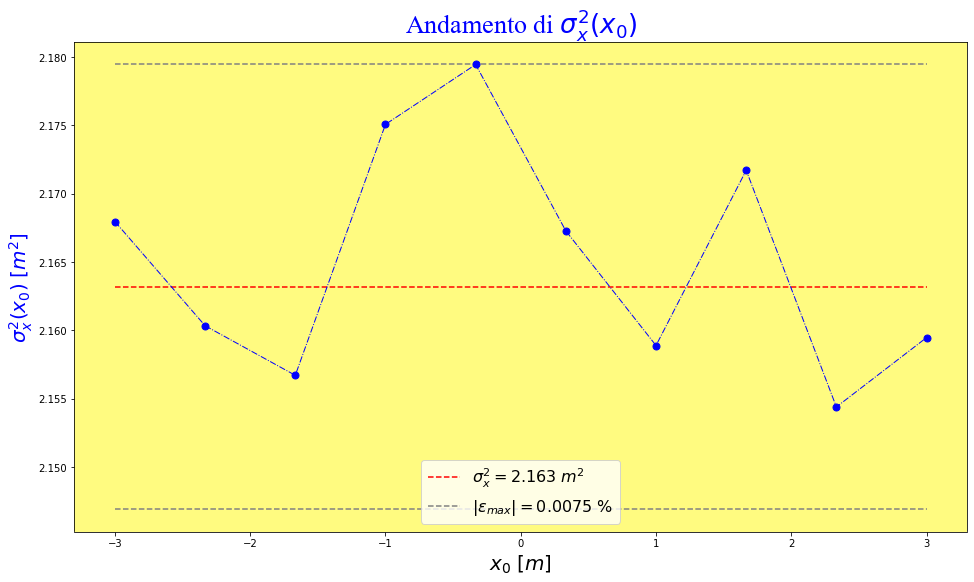

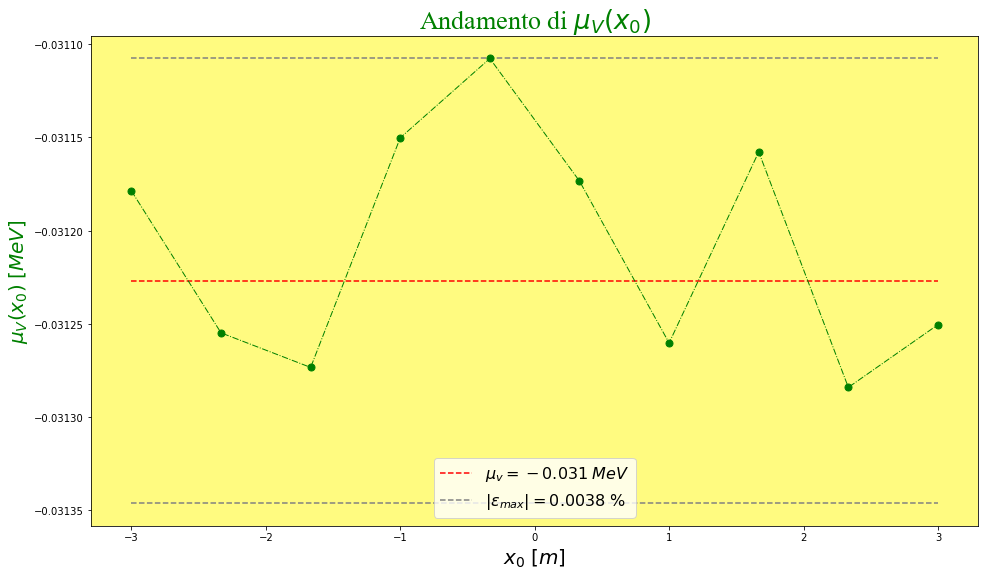

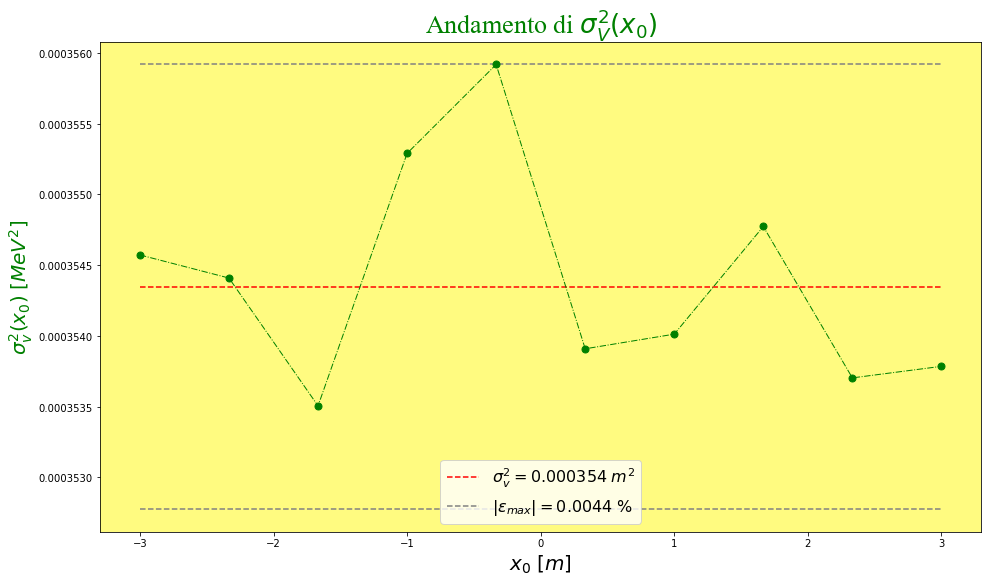

In [90]:
#Media su x al variare di x0

er_max = max( abs(av_x_list - μ_x) )

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#fffb80')
plt.title('Andamento di $\mu_x (x_0)$', fontdict = font1, c='b')

plt.plot([x_start,x_stop], [μ_x,μ_x], '--r', label='$\mu_x ='+str(round(μ_x,3))+'\; m$')
plt.plot([x_start,x_stop], [μ_x + er_max, μ_x + er_max], '--', c='grey',
         label='$|\epsilon_{max}| =' + str(round(er_max/abs(μ_x), 4)) + '$ %')
plt.plot([x_start,x_stop], [μ_x - er_max, μ_x - er_max], '--', c='grey')
plt.plot(x0_list, av_x_list, 'o-.b', lw=1, ms=7)

plt.xlabel('$x_0 \; [m]$', size=20)
plt.ylabel('$\mu_x (x_0) \; [m]$', c='b', size=20)
plt.legend(fontsize=16)
plt.show()


#Varianza su x al variare di x0

er_max = max( abs(var_x_list - σ2_x) )

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#fffb80')
plt.title('Andamento di $\sigma^2_x (x_0)$', fontdict = font1, c='b')

plt.plot([x_start,x_stop], [σ2_x,σ2_x], '--r', label='$\sigma^2_x ='+str(round(σ2_x,3))+'\; m^2$')
plt.plot([x_start,x_stop], [σ2_x + er_max, σ2_x + er_max], '--', c='grey',
         label='$|\epsilon_{max}| =' + str(round(er_max/σ2_x, 4)) + '$ %')
plt.plot([x_start,x_stop], [σ2_x - er_max, σ2_x - er_max], '--', c='grey')
plt.plot(x0_list, var_x_list, 'o-.b', lw=1, ms=7)

plt.xlabel('$x_0 \; [m]$', size=20)
plt.ylabel('$\sigma^2_x (x_0) \; [m^2]$', c='b', size=20)
plt.legend(fontsize=16)
plt.show()


#Media su V(x) al variare di x0

er_max = max( abs(av_v_list - μ_v) )

plt.figure(figsize=(15.9,9))
ax=plt.axes()
ax.set_facecolor('#fffb80')
plt.title('Andamento di $\mu_V (x_0)$', fontdict = font1, c='g')

plt.plot([x_start,x_stop], [μ_v,μ_v], '--r', label='$\mu_v ='+str(round(μ_v,3))+'\; MeV$')
plt.plot([x_start,x_stop], [μ_v + er_max, μ_v + er_max], '--', c='grey',
         label='$|\epsilon_{max}| =' + str(round(er_max/abs(μ_v), 4)) + '$ %')
plt.plot([x_start,x_stop], [μ_v - er_max, μ_v - er_max], '--', c='grey')
plt.plot(x0_list, av_v_list, 'o-.g', lw=1, ms=7)

plt.xlabel('$x_0 \; [m]$', size=20)
plt.ylabel('$\mu_V (x_0) \; [MeV]$', c='g', size=20)
plt.legend(fontsize=16)
plt.show()


#Varianza su V(x) al variare di x0

er_max = max( abs(var_v_list - σ2_v) )

plt.figure(figsize=(15.8,9))
ax=plt.axes()
ax.set_facecolor('#fffb80')
plt.title('Andamento di $\sigma^2_V (x_0)$', fontdict = font1, c='g')

plt.plot([x_start,x_stop], [σ2_v,σ2_v], '--r', label='$\sigma^2_v ='+str(round(σ2_v,6))+'\; m^2$')
plt.plot([x_start,x_stop], [σ2_v + er_max, σ2_v + er_max], '--', c='grey',
         label='$|\epsilon_{max}| =' + str(round(er_max/σ2_v, 4)) + '$ %')
plt.plot([x_start,x_stop], [σ2_v - er_max, σ2_v - er_max], '--', c='grey')
plt.plot(x0_list, var_v_list, 'o-.g', lw=1, ms=7)

plt.xlabel('$x_0 \; [m]$', size=20)
plt.ylabel('$\sigma^2_v (x_0) \; [MeV^2]$', c='g', size=20)
plt.legend(fontsize=16)
plt.show()

In [9]:
#Studio di x e V(x) al variare di T

t0=time()

μ_v_lim  = round( integrate(V)/(x5 - x1), 6)
σ2_v_lim = round( integrate(lambda x: (V(x) - μ_v_lim)**2)/(x5 - x1), 6)

av_x_list1, var_x_list1 = [], []
av_v_list1, var_v_list1 = [], []

print('Fase 1 di 2...\n')
j=0
for t in t_list:
    j+=1
    Metropolis(T=t)
    
    av_x_list1.append(av_x)
    av_v_list1.append(av_v)
    var_x_list1.append(var_x)
    var_v_list1.append(var_v)
    print('Completamento operazione:',round(100*j/len(t_list), 1),'%')

j=0
t=time()-t0
print('\nTempo di esecuzione:',int(t//60),'m',int(round(t%60,0)),'s\n\nFase 2 di 2...\n')


T_array    = np.linspace(Ti, Tf, 200)
μ_x_array  = []
σ2_x_array = []
μ_v_array  = []
σ2_v_array = []
n1 = 10**5

t0=time()
for t in T_array:
    j+=1
    
    z    = round(integrate(lambda x: p(x,t), n=n1), 10)
    μ_x  = integrate(lambda x: x*p(x,t), n=n1)/z
    σ2_x = integrate(lambda x: (x - μ_x)**2*p(x,t), n=n1)/z
    μ_v  = integrate(lambda x: V(x)*p(x,t), n=n1)/z
    σ2_v = integrate(lambda x: (V(x) - μ_v)**2*p(x,t), n=n1)/z
    
    μ_x_array.append(μ_x)
    σ2_x_array.append(σ2_x)
    μ_v_array.append(μ_v)
    σ2_v_array.append(σ2_v)
    print('Completamento operazione:',round(100*j/len(T_array), 1),'%')

t=time()-t0
print('\nTempo di esecuzione:',int(t//60),'m',int(round(t%60,0)),'s')

Fase 1 di 2...

Completamento operazione: 10.0 %
Completamento operazione: 20.0 %
Completamento operazione: 30.0 %
Completamento operazione: 40.0 %
Completamento operazione: 50.0 %
Completamento operazione: 60.0 %
Completamento operazione: 70.0 %
Completamento operazione: 80.0 %
Completamento operazione: 90.0 %
Completamento operazione: 100.0 %

Tempo di esecuzione: 6 m 14 s

Fase 2 di 2...

Completamento operazione: 0.5 %
Completamento operazione: 1.0 %
Completamento operazione: 1.5 %
Completamento operazione: 2.0 %
Completamento operazione: 2.5 %
Completamento operazione: 3.0 %
Completamento operazione: 3.5 %
Completamento operazione: 4.0 %
Completamento operazione: 4.5 %
Completamento operazione: 5.0 %
Completamento operazione: 5.5 %
Completamento operazione: 6.0 %
Completamento operazione: 6.5 %
Completamento operazione: 7.0 %
Completamento operazione: 7.5 %
Completamento operazione: 8.0 %
Completamento operazione: 8.5 %
Completamento operazione: 9.0 %
Completamento operazione: 9.5

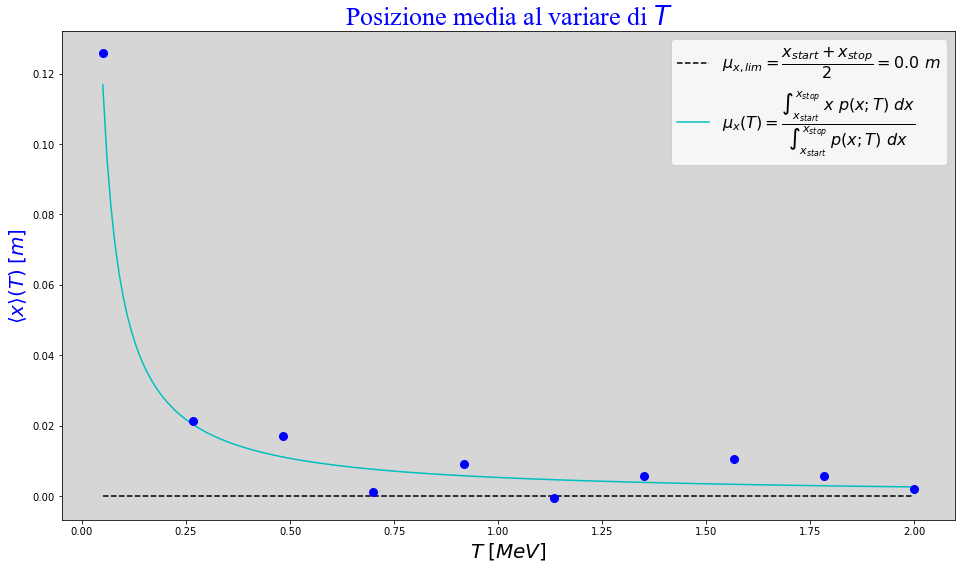

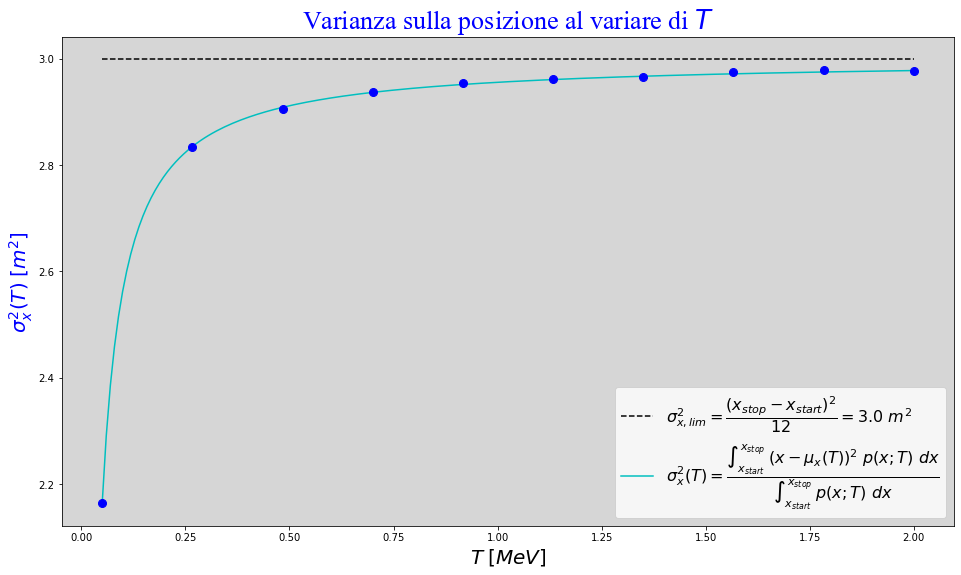

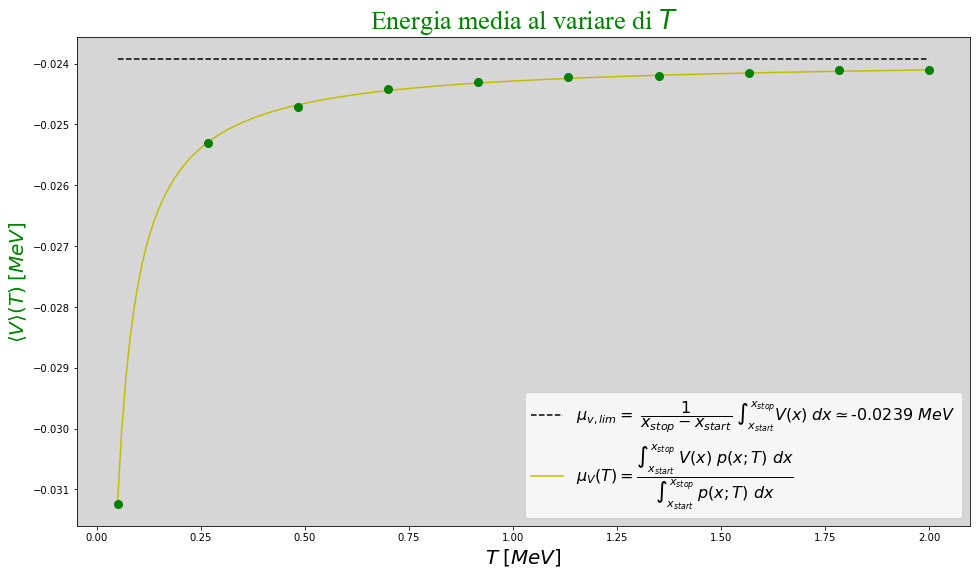

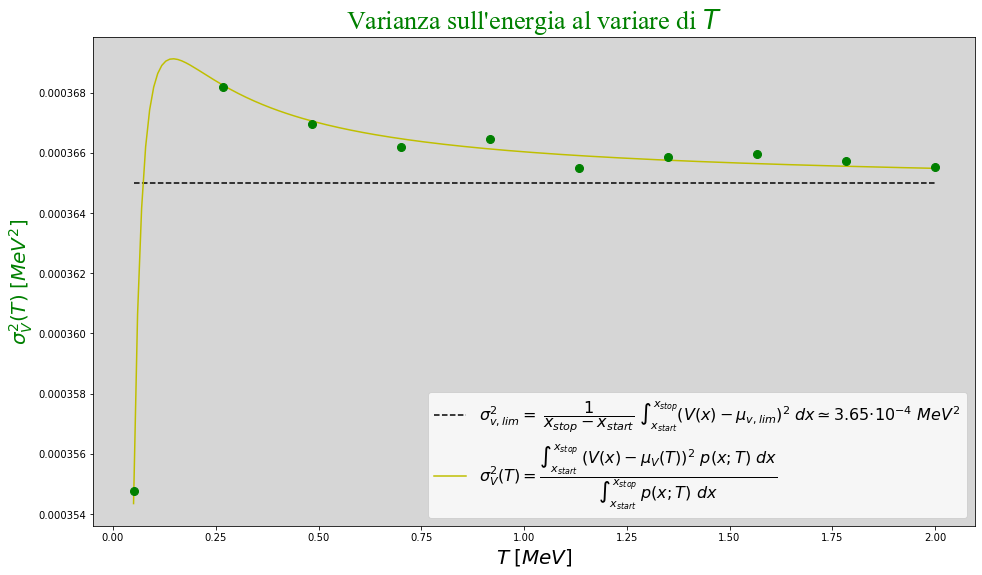

In [10]:
#x media al crescere di T

label1 = '$\mu_x(T)= \dfrac{ \int_{x_{start}}^{x_{stop}} \; x\ p(x;T)\ dx }{ \int_{x_{start}}^{x_{stop}}\; p(x;T)\ dx }$'
label2 = '$\sigma^2_x(T)= \dfrac{ \int_{x_{start}}^{x_{stop}} \; (x-\mu_x(T))^2\ p(x;T)\ dx }{ \int_{x_{start}}^{x_{stop}}\; p(x;T)\ dx }$'
label3 = '$\mu_V(T)= \dfrac{ \int_{x_{start}}^{x_{stop}} \; V(x)\ p(x;T)\ dx }{ \int_{x_{start}}^{x_{stop}}\; p(x;T)\ dx }$'
label4 = '$\sigma^2_V(T)= \dfrac{ \int_{x_{start}}^{x_{stop}} \; (V(x)-\mu_V(T))^2\ p(x;T)\ dx }{ \int_{x_{start}}^{x_{stop}}\; p(x;T)\ dx }$'

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Posizione media al variare di $T$', fontdict = font1, c='blue')

plt.plot([Ti, Tf], [(x1+x5)/2, (x1+x5)/2], '--k',
         label=r'$\mu_{x, lim} = \dfrac{x_{start}+x_{stop}}{2}=$' +str(round((x1+x5)/2,4))+ '$\ m$')
plt.plot(T_array, μ_x_array, 'c', label=label1)
plt.plot(t_list, av_x_list1, 'o b', ms=8)

plt.xlabel('$T \; [MeV]$', size=20)
plt.ylabel(r'$\langle x \rangle (T) \; [m]$', c='blue', size=20)
plt.legend(fontsize=16)
plt.show()


#varianza su x al crescere di T

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Varianza sulla posizione al variare di $T$', fontdict = font1, c='blue')

plt.plot([Ti, Tf], [(x5-x1)**2/12, (x5-x1)**2/12], '--k',
         label=r'$\sigma^2_{x, lim} = \dfrac{(x_{stop}-x_{start})^2}{12}=$' +str(round((x5-x1)**2/12,4))+ '$\ m^2$')
plt.plot(T_array, σ2_x_array, 'c', label=label2)
plt.plot(t_list, var_x_list1, 'o b', ms=8)

plt.xlabel('$T \; [MeV]$', size=20)
plt.ylabel(r'$\sigma_x^2 (T) \; [m^2]$', c='blue', size=20)
plt.legend(fontsize=16)
plt.show()


#V(x) media al crescere di T

plt.figure(figsize=(16,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title('Energia media al variare di $T$', fontdict = font1, c='g')

plt.plot([Ti, Tf], [μ_v_lim, μ_v_lim], '--k',
         label=r'$\mu_{v, lim} =\; \dfrac{1}{x_{stop}-x_{start}}\; \int_{x_{start}}^{x_{stop}}V(x) \; dx \simeq$' +str(round(μ_v_lim,4))+ '$\ MeV$')
plt.plot(T_array, μ_v_array, 'y', label=label3)
plt.plot(t_list, av_v_list1, 'o g', ms=8)

plt.xlabel('$T \; [MeV]$', size=20)
plt.ylabel(r'$\langle V \rangle (T) \; [MeV]$', c='g', size=20)
plt.legend(fontsize=16)
plt.show()


#varianza su V(x) al crescere di T

plt.figure(figsize=(15.8,9))
ax=plt.axes()
ax.set_facecolor('#d6d6d6')
plt.title("Varianza sull'energia al variare di $T$", fontdict = font1, c='g')

plt.plot([Ti, Tf], [σ2_v_lim, σ2_v_lim], '--k',
         label=r'$\sigma^2_{v, lim}= \; \dfrac{1}{x_{stop}-x_{start}} \; \int_{x_{start}}^{x_{stop}} (V(x) - \mu_{v, lim})^2 \; dx \simeq$' +str(round(10**4*σ2_v_lim,3))+ '$\cdot 10^{-4}\ MeV^2$')
plt.plot(T_array, σ2_v_array, 'y', label=label4)
plt.plot(t_list, var_v_list1, 'o g', ms=8)

plt.xlabel('$T \; [MeV]$', size=20)
plt.ylabel(r'$\sigma_V^2 (T) \; [MeV^2]$', c='g', size=20)
plt.legend(fontsize=16, loc='lower right')
plt.show()